## Check observables given a results file from a `TRSL` simulation

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [92]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from statsmodels.nonparametric.smoothers_lowess import lowess

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [2]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

In [3]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150818_1920_3599s.p"

Make file readable by `ipython` in case it was created by `pypy`:

In [4]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [5]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [6]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [7]:
size = 4
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

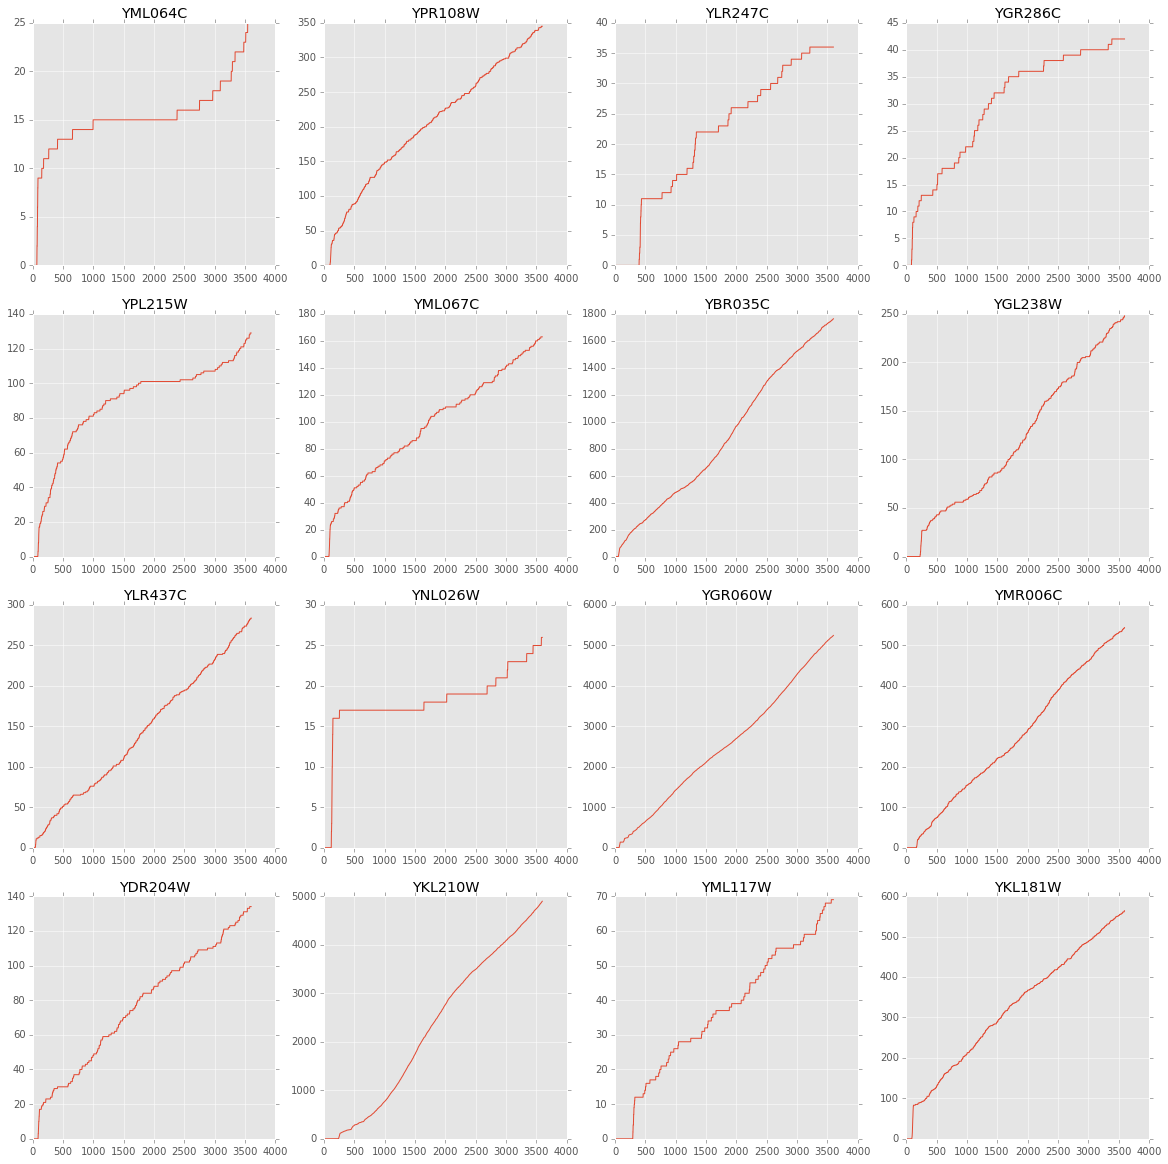

In [8]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        ax[i, j].plot(results['timerange'], results['timecourses'][protnames_plot[i][j]])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation (TODO: start and stop should be automatic):

In [9]:
start, stop = 599, 3599  # to exclude the "burn in" phase
prot_speeds = {}

for prot in protnames:
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * stop - start)
    if prot_speeds[prot] > 50: 
        print prot, prot_speeds[prot]

YKL060C 78.9
YAL038W 113.273333333
YCR012W 62.2076666667
YOL086C 50.837
YLR044C 255.591666667
YOL040C 52.4876666667


In [10]:
pd.Series(prot_speeds.values()).describe()

count    2496.000000
mean        1.035836
std         6.943294
min         0.000667
25%         0.024667
50%         0.070000
75%         0.243000
max       255.591667
dtype: float64

Distribution of translation speeds (finished protein molecules per second):

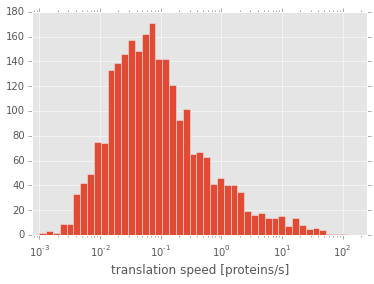

In [11]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

In [12]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [13]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [14]:
pd.Series(peptide_speeds.values()).describe()

count      2496.000000
mean        377.096605
std        3414.163554
min           0.340000
25%           9.370333
50%          25.617833
75%          87.378250
max      144153.700000
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second):

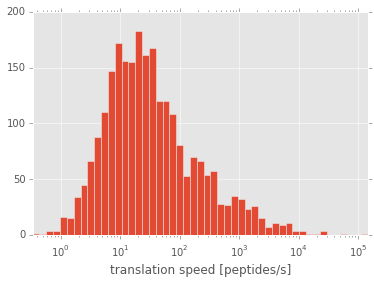

In [15]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [16]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
print len(init_rates_plotkin)

2569


In [17]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())

4839
60000


In [18]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin']

In [19]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')

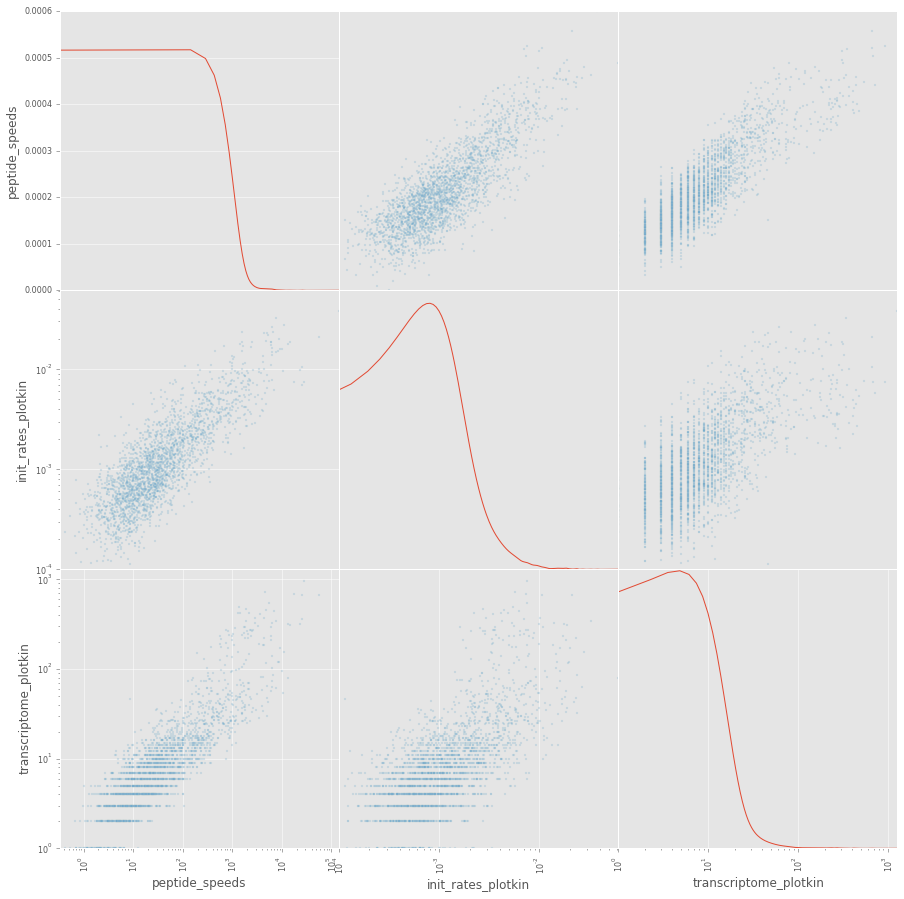

In [20]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')         

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs:

In [22]:
filepath = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150825_1823_3599s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [23]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(filepath))

The following is smaller than 20000 (or 19969 as in the original file), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [24]:
len(results['transcriptome'])

16724

In [25]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [26]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

In [27]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [28]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [29]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [30]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [31]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic_toc']

In [32]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [33]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [34]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [35]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'orf_length']

In [36]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

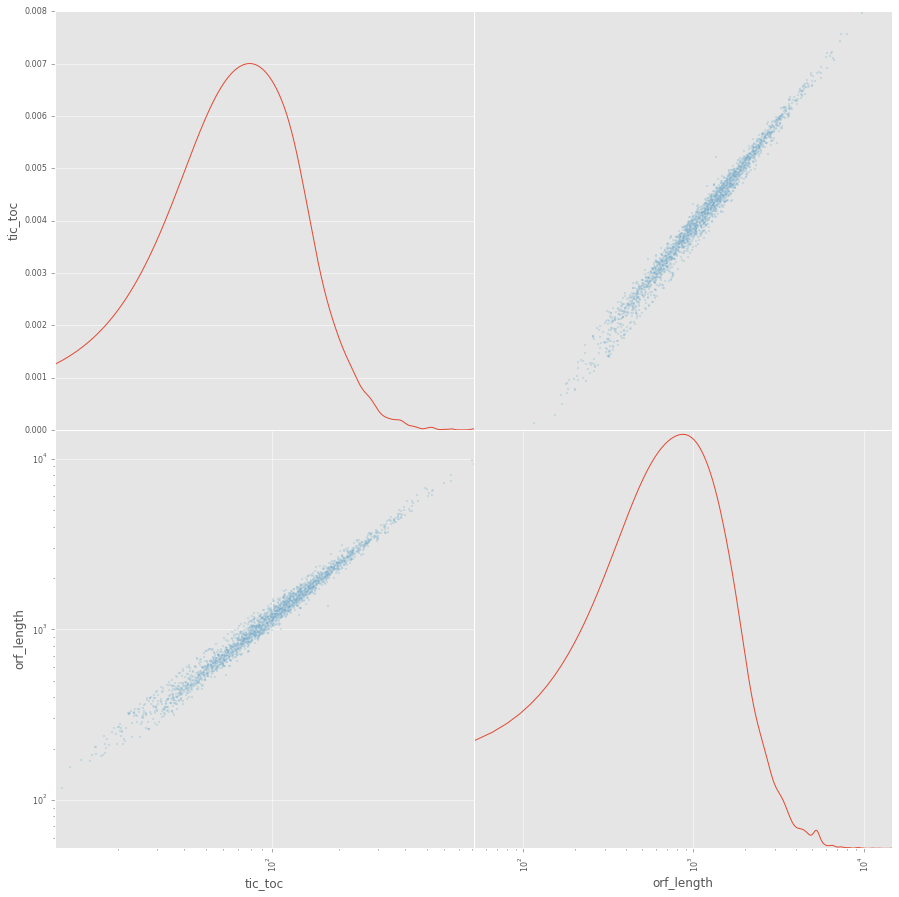

In [37]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')            

In [38]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [39]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    2415.000000
mean        0.084858
std         0.007183
min         0.065803
25%         0.080472
50%         0.084706
75%         0.088999
max         0.131732
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([   5.,   11.,   12.,   21.,   17.,   25.,   24.,   43.,   30.,
          48.,   51.,   65.,   84.,   93.,  119.,  133.,  153.,  153.,
         138.,  145.,  137.,  163.,  118.,   86.,   97.,   69.,   69.,
          70.,   50.,   40.,   29.,   23.,   18.,   14.,   17.,    6.,
           4.,    3.,    9.,    6.,    2.,    5.,    4.,    3.,    0.,
           0.,    0.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0.06580341,  0.06680341,  0.06780341,  0.06880341,  0.06980341,
         0.07080341,  0.07180341,  0.07280341,  0.07380341,  0.07480341,
         0.07580341,  0.07680341,  0.07780341,  0.07880341,  0.07980341,
         0.08080341,  0.08180341,  0.08280341,  0.08380341,  0.08480341,
         0.08580341,  0.08680341,  0.08780341,  0.08880341,  0.08980341,
         0.09080341,  0.09180341,  0.09280341,  0.09380341,  0.09480341,
         0.09580341,  0.09680341,  0.0978

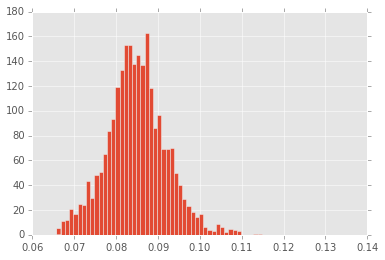

In [40]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.001))


In [41]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

(array([   1.,    0.,    0.,    1.,    1.,   12.,   19.,   19.,   53.,
          97.,  172.,  201.,  291.,  323.,  303.,  288.,  200.,  137.,
          92.,   56.,   57.,   34.,   27.,   18.,   11.]),
 array([ 2.53039455,  2.63039455,  2.73039455,  2.83039455,  2.93039455,
         3.03039455,  3.13039455,  3.23039455,  3.33039455,  3.43039455,
         3.53039455,  3.63039455,  3.73039455,  3.83039455,  3.93039455,
         4.03039455,  4.13039455,  4.23039455,  4.33039455,  4.43039455,
         4.53039455,  4.63039455,  4.73039455,  4.83039455,  4.93039455,
         5.03039455]),
 <a list of 25 Patch objects>)

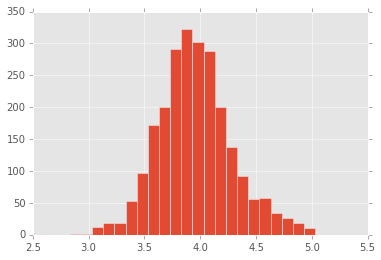

In [42]:
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.1))

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [43]:
import shelve

filepath = "../results/ribosome_timecourses_20150918_0630.db"
d = shelve.open(filepath)

In [45]:
resultsfile = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150918_0751_1799s.p"
replace(resultsfile, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(resultsfile))

Populate a dictionary with ribosome "lattices":

In [46]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    #print mRNA.index
    #print mRNA.geneID
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

To make the ribosomes into a data frame, all array have to have the same length:

In [48]:
max_codons = len(max(ribo_lattice_dict.values(), key=len))

for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [49]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)
ribo_lattice_df

,YAL001C,YAL003W,YAL007C,YAL008W,YAL012W,YAL016W,YAL022C,YAL023C,YAL025C,YAL029C,YAL033W,YAL035W,YAL036C,YAL038W,YAL042W,YAL044C,YAL046C,YAL059W,YAL060W,YAR002W,
0,1,18,0,0,6,0,0,0,0,0,0,1,0,76,0,0,0,1,0,1,...
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
3,0,2,0,0,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,...
4,0,7,0,0,0,0,0,1,0,0,0,1,0,4,0,0,0,0,0,0,...
5,0,12,1,0,1,0,0,0,0,0,0,1,0,28,0,0,0,0,0,0,...
6,0,4,0,0,0,0,0,0,0,0,0,0,0,33,0,1,0,0,0,0,...
7,0,1,0,0,1,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,...
8,0,5,0,0,2,0,0,1,0,0,0,0,0,20,0,0,0,0,0,0,...
9,0,5,0,0,0,0,0,0,0,0,0,1,0,18,0,0,0,0,0,0,...


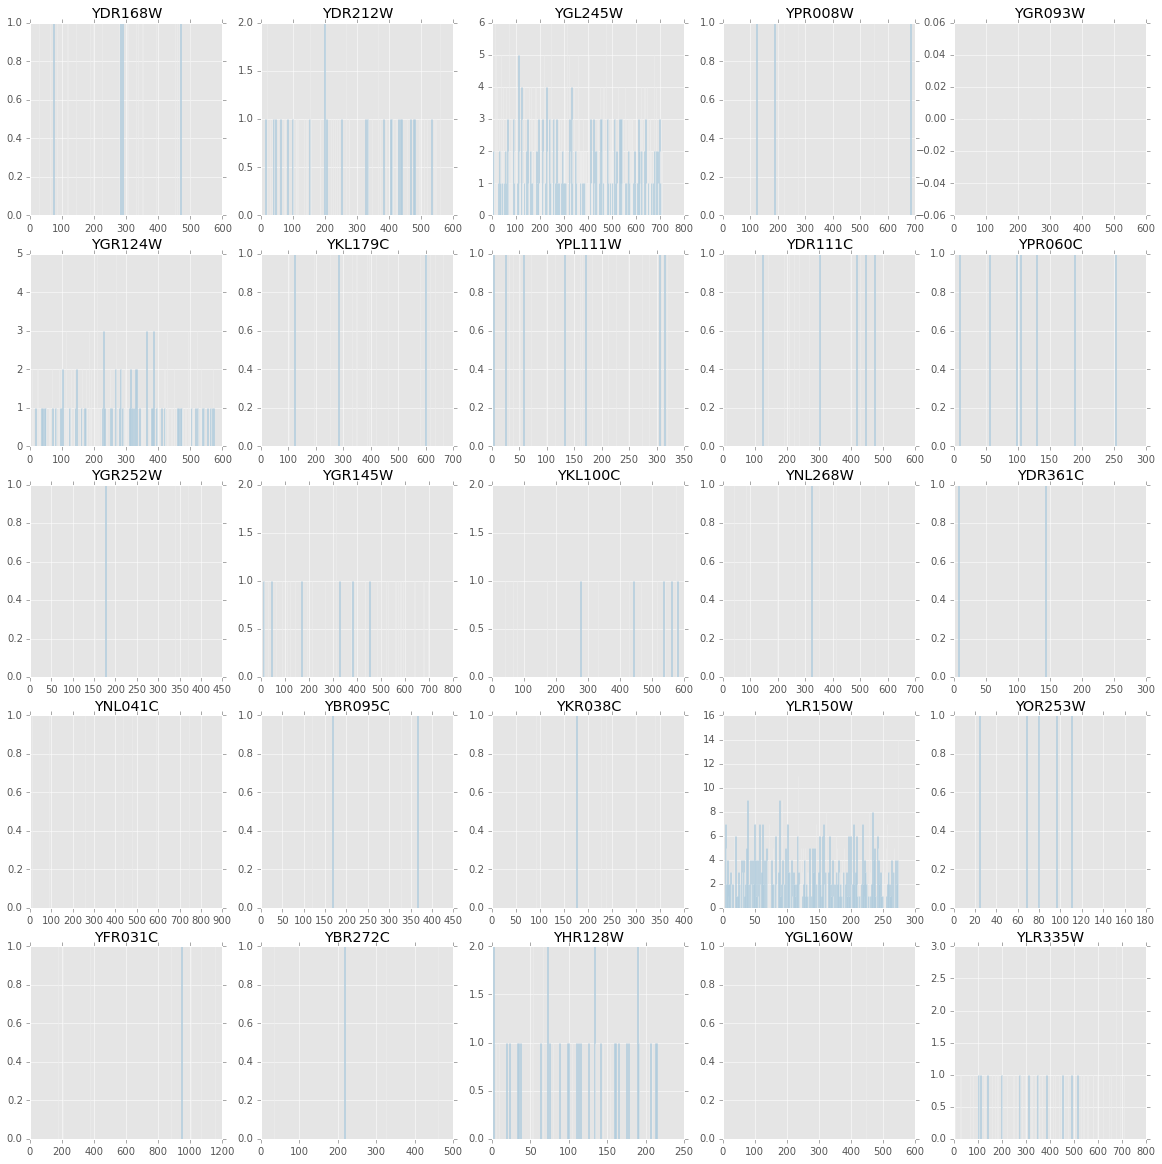

In [51]:
size = 5
genenames_plot = np.array(random.sample(ribo_lattice_dict.keys(), size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]] if elem is not None]
        ax[i, j].bar(range(len(plotlist)), plotlist)
        ax[i, j].set_title(genenames_plot[i][j])   


Average ribosome number per gene (average along the mRNA, across all codons):

In [102]:
average_ribos_per_gene = dict(ribo_lattice_df.mean(numeric_only=None))

Normalize by transcript abundance:

In [103]:
transcriptome = pkl.load(open("../parameters/transcriptome_plotkin_20000.p", "rb"))
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", "rb"))

In [104]:
average_ribos_per_transcript = {gene: average_ribos_per_gene[gene]/transcriptome[gene] 
                                for gene in average_ribos_per_gene 
                                if average_ribos_per_gene[gene]/transcriptome[gene]>1e-10}

Function to plot two dictionaries by their values:

In [98]:
def scatter_dicts(dict1, dict2):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlabel('Stansfield initiation rates')
    #ax.set_ylabel('Plotkin initiation rates')

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

Plot against initiation rate:

2380


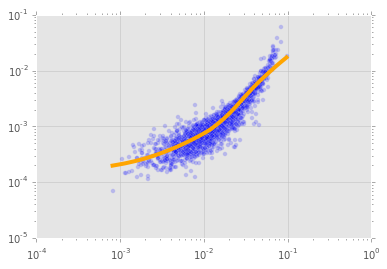

In [105]:
scatter_dicts(average_ribos_per_transcript, init_rates)

Interesting: why is there still dispersion?

In [112]:
means_per_position = ribo_lattice_df.mean(axis=1, numeric_only=None)
means_per_position

0     1.094824
1     0.009524
2     0.024845
3     0.097308
4     0.302692
5     0.418634
6     0.258385
7     0.139130
8     0.171843
9     0.245135
10    0.322153
11    0.238095
12    0.179710
13    0.195859
14    0.234369
...
3254    0
3255    0
3256    0
3257    0
3258    0
3259    0
3260    0
3261    0
3262    0
3263    0
3264    0
3265    0
3266    2
3267    0
3268    0
Length: 3269, dtype: float64

In [137]:
positions = len(means_per_position)
# not all genes in the transcriptome have an orf_length, why?
transcripts_per_position = [sum([transcriptome[gene] for gene in transcriptome 
                            if gene in orf_lengths and position+1 <= orf_lengths[gene]/3])
                            for position in range(positions)]
len(transcripts_per_position)

3269

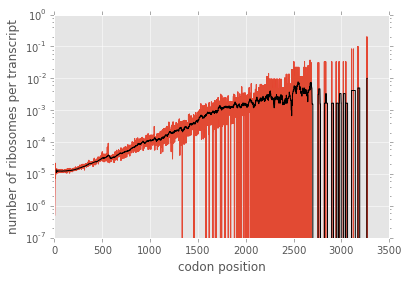

In [140]:
ts = means_per_position/np.array(transcripts_per_position)
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
plt.yscale('log') 
pd.rolling_mean(ts, 20).plot(style='k')

I think we only see that there are fewer (denominator!) transcripts with lengths larger than codon position...

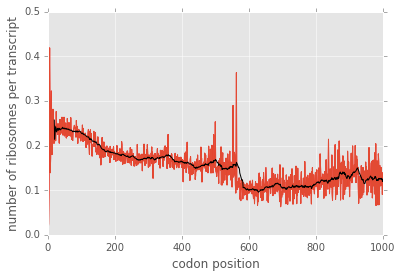

In [146]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
plt.xlim([0, 1000])
plt.ylim([0, 0.5])
pd.rolling_mean(ts, 20).plot(style='k')

Better, with ribosome ramp.